<a href="https://colab.research.google.com/github/patriciapaula/data-science/blob/master/%5B1%5Dgrafico_interativo_malha_fundiaria_ceara.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mapas Interativos da malha fundiária do Ceará

## ⚠️ PARADA OBRIGATÓRIA: Como utilizar este ambiente

Todos os códigos foram escondidos para que se possa usar o software sem precisar visualizar seu código.

Porém, para que apareça a o gráfico ou mapa que se deseja é reciso apertar o botão de PLAY (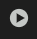) e aguardar que apareça a confirmação de que o código foi executado com sucesso. Esta informação é mostrada através de CHECK (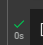) que aparece ao lado do botão de PLAY.

A tela que deve ser visualizada nessa aplicação pode ser vista a seguir:


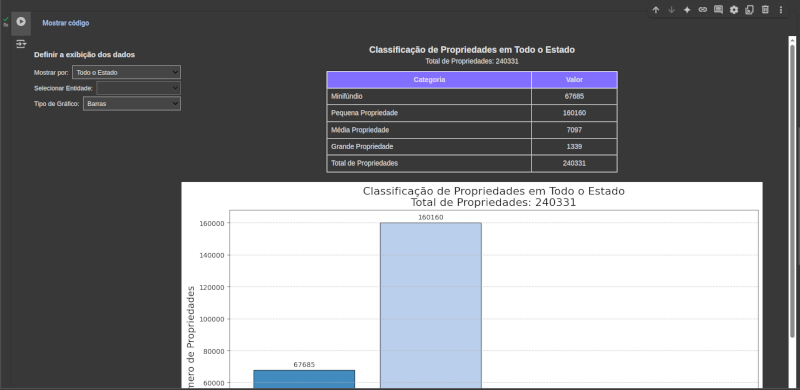

Figura 01: Tela de Gráficos da Malha Fundiária do Ceará


Não esqueça de usar a barra de rolagem (ver Figura 02) para conseguir ter acesso às informações iniciais do gráfico interativo.


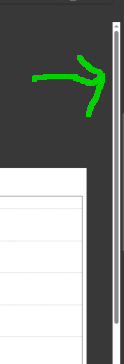

Figura 02: Barra de Rolagem

## Ler os dados das propriedades rurais cadastrados no IDACE

In [1]:
# @title
import pandas as pd
import numpy as np  # Para garantir o uso de np.nan como padrão
from google.colab import drive
drive.mount('/content/drive')

# Caminho do arquivo no Google Drive
file_path = '/content/drive/MyDrive/Projetos/2024-governanca-fundiaria/[DATA-TO-ANALYSIS]/data_to_colab/dataset-malha-fundiaria-idace_preprocessado-2025-03-21-19-29-16.csv'

# Carregar o arquivo CSV
data = pd.read_csv(file_path, low_memory=False)

Mounted at /content/drive


## Mapeamento das propriedades por tamanho

1. Minifúndio: 0 < àrea < 1MF
2. Pequena Propriedade: 1 MF ≤ àrea ≤ 4 MF
3. Média Propriedade: 4 MF < àrea ≤ 15 MF
4. Grande Propriedade: àrea >15 MF

> A classificação é definida pela Lei 8.629, de 25 de fevereiro de 1993, alterada pela Lei nº 13.465  de 2017, e considera o módulo fiscal, que varia de acordo com cada município. O módulo fiscal é um dos Índices Básicos Cadastrais utilizados pelo Incra para fixar por município parâmetros de caracterização e classificação do imóvel rural de acordo com a sua dimensão e disposição regional. Os atuais índices foram definidos pelo Incra por meio da Instrução Especial nº 5 de 2022.

In [2]:
# @title
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Dropdown, VBox, HBox, Output, HTML as WidgetHTML
from IPython.display import display, HTML

# =============================================================================
# Funções de Filtragem e Classificação
# =============================================================================

def filtrar_dados(data, filtro, entidade):
    """
    Filtra o DataFrame 'data' conforme o tipo de filtro:
      - "Municípios": filtra pelo nome do município.
      - "Regiões Administrativas": filtra pela região administrativa.
      - "Todo o Estado": retorna todos os dados.
    """
    if filtro == "Municípios":
        return data[data['nome_municipio'] == entidade]
    elif filtro == "Regiões Administrativas":
        return data[data['regiao_administrativa'] == entidade]
    elif filtro == "Todo o Estado":
        return data
    return pd.DataFrame()

def classificar_propriedades(df):
    """
    Classifica as propriedades com base em seu tamanho em relação ao módulo fiscal de cada registro:
        1. Minifúndio: 0 < àrea < 1MF
        2. Pequena Propriedade: 1 MF ≤ àrea ≤ 4 MF
        3. Média Propriedade: 4 MF < àrea ≤ 15 MF
        4. Grande Propriedade: àrea >15 MF
    Retorna um dicionário com a contagem exata de propriedades em cada categoria e o total.
    """

    # Descartar propriedades com área ou módulo fiscal vazios
    df = df.dropna(subset=['area', 'modulo_fiscal'])

    # Descartar propriedades com área ou módulo fiscal iguais a zero
    df = df[(df['area'] != 0) & (df['modulo_fiscal'] != 0)]

    # Retornar None, caso não haja nenhuma propriedade com área e módulo fiscal válida
    if df.empty:
        return None, None

    cond_minifundio = (df['area'] > 0) & (df['area'] < 1 * df['modulo_fiscal'])
    cond_pequena    = (df['area'] >= 1 * df['modulo_fiscal']) & (df['area'] <= 4 * df['modulo_fiscal'])
    cond_media      = (df['area'] > 4 * df['modulo_fiscal']) & (df['area'] <= 15 * df['modulo_fiscal'])
    cond_grande     = (df['area'] > 15 * df['modulo_fiscal'])

    resultados = {
        "Minifundio": int(cond_minifundio.sum()),
        "Pequena Propriedade": int(cond_pequena.sum()),
        "Média Propriedade": int(cond_media.sum()),
        "Grande Propriedade": int(cond_grande.sum())
    }
    total = len(df)
    return resultados, total

# =============================================================================
# Função para Exibir Informações em Tabela (Classificação)
# =============================================================================

def display_info_table(titulo, subtitulo, total, resultados):
    """
    Exibe as informações de classificação em uma tabela HTML estilizada.
    """
    info_html = f"""
    <div style="margin-bottom:20px;">
      <table style="width:50%; border-collapse: collapse; margin: auto; box-shadow: 0px 0px 8px rgba(0,0,0,0.1);">
        <caption style="caption-side: top; font-size: 18px; font-weight: bold; padding: 10px;">
          {titulo}<br>
          <span style="font-size: 14px; font-weight: normal;">{subtitulo}</span>
        </caption>
        <thead>
          <tr style="background-color: #836FFF;">
            <th style="padding: 8px; border: 1px solid #fff;">Categoria</th>
            <th style="padding: 8px; border: 1px solid #fff;">Valor</th>
          </tr>
        </thead>
        <tbody>
          <tr>
            <td style="padding: 8px; border: 1px solid #ddd;">Minifúndio</td>
            <td style="padding: 8px; border: 1px solid #ddd; text-align: center;">{resultados.get("Minifundio", 0)}</td>
          </tr>
          <tr>
            <td style="padding: 8px; border: 1px solid #ddd;">Pequena Propriedade</td>
            <td style="padding: 8px; border: 1px solid #ddd; text-align: center;">{resultados.get("Pequena Propriedade", 0)}</td>
          </tr>
          <tr>
            <td style="padding: 8px; border: 1px solid #ddd;">Média Propriedade</td>
            <td style="padding: 8px; border: 1px solid #ddd; text-align: center;">{resultados.get("Média Propriedade", 0)}</td>
          </tr>
          <tr>
            <td style="padding: 8px; border: 1px solid #ddd;">Grande Propriedade</td>
            <td style="padding: 8px; border: 1px solid #ddd; text-align: center;">{resultados.get("Grande Propriedade", 0)}</td>
          </tr>
          <tr>
            <td style="padding: 8px; border: 1px solid #ddd;">Total de Propriedades</td>
            <td style="padding: 8px; border: 1px solid #ddd; text-align: center;">{total}</td>
          </tr>
        </tbody>
      </table>
    </div>
    """
    display(HTML(info_html))

# =============================================================================
# Funções de Plotagem
# =============================================================================

# Add this near the top of the code (with other constants)
cores = {
    "Minifúndio": "#9b19f5",
    "Pequena Propriedade": "#0040bf",
    "Média Propriedade": "#e6d800",
    "Grande Propriedade": "#d97f00",
    "Sem Registro": "#9fa2a5"
}

# Modify the plot_barras function:
def plot_barras(resultados, titulo, subtitulo):
    """
    Plota gráfico de barras com os valores e anota os totais acima de cada barra.
    """
    # Map category names to colors
    color_map = {
        "Minifundio": cores["Minifúndio"],
        "Pequena Propriedade": cores["Pequena Propriedade"],
        "Média Propriedade": cores["Média Propriedade"],
        "Grande Propriedade": cores["Grande Propriedade"]
    }

    # Get colors in correct order
    colors = [color_map[cat] for cat in resultados.keys()]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(resultados.keys(), resultados.values(), color=colors, edgecolor='black', alpha=0.85)
    plt.title(f"{titulo}\n{subtitulo}", fontsize=16)
    plt.xlabel("Categoria", fontsize=14)
    plt.ylabel("Número de Propriedades", fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=12)

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width()/2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

# Modify the plot_pizza function:
def plot_pizza(resultados, titulo, subtitulo):
    """
    Plota gráfico de pizza com percentuais e legenda.
    Esse gráfico é tão gostoso quanto uma fatia de pizza (sem exageros, ok?).
    """
    # Map category names to colors
    color_map = {
        "Minifundio": cores["Minifúndio"],
        "Pequena Propriedade": cores["Pequena Propriedade"],
        "Média Propriedade": cores["Média Propriedade"],
        "Grande Propriedade": cores["Grande Propriedade"]
    }

    # Get colors in correct order
    colors = [color_map[cat] for cat in resultados.keys()]

    plt.figure(figsize=(10, 10))
    wedges, texts, autotexts = plt.pie(list(resultados.values()),
                                       labels=None,
                                       autopct='%1.1f%%',
                                       startangle=90,
                                       colors=colors,
                                       pctdistance=0.8)
    plt.title(f"{titulo}\n{subtitulo}", fontsize=16)
    plt.axis('equal')
    plt.legend(wedges, resultados.keys(), title="Tipos de Propriedade",
               loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.tight_layout()
    plt.show()

# =============================================================================
# Função para Exibir Estatísticas Adicionais em Tabela
# =============================================================================

def display_stats_table(data):
    """
    Exibe uma tabela com estatísticas adicionais do dataset da Malha Fundiária.
    É como o "por trás das câmeras" que revela todos os segredos!
    """
    total_properties = len(data)
    missing_area = data['area'].isna().sum()
    missing_modulo = data['modulo_fiscal'].isna().sum()

    valid_data = data.dropna(subset=['area', 'modulo_fiscal'])
    valid_data = valid_data[(valid_data['area'] != 0) & (valid_data['modulo_fiscal'] != 0)]
    valid_data = valid_data[valid_data['nome_municipio'].notna()]
    total_valid = len(valid_data)

    total_municipios = len(data['nome_municipio'].dropna().unique())
    valid_municipios = len(valid_data['nome_municipio'].dropna().unique())

    # Classificação por município (para determinar a categoria dominante)
    conditions = [
        (valid_data['area'] > 0) & (valid_data['area'] < 1 * valid_data['modulo_fiscal']),
        (valid_data['area'] >= 1 * valid_data['modulo_fiscal']) & (valid_data['area'] <= 4 * valid_data['modulo_fiscal']),
        (valid_data['area'] > 4 * valid_data['modulo_fiscal']) & (valid_data['area'] <= 15 * valid_data['modulo_fiscal']),
        (valid_data['area'] > 15 * valid_data['modulo_fiscal'])
    ]
    choices = ["Minifundio", "Pequena Propriedade", "Média Propriedade", "Grande Propriedade"]
    valid_data = valid_data.copy()
    valid_data['categoria'] = np.select(conditions, choices, default="NaoClassificado")

    # Determinar a categoria dominante para cada município
    dominancia = valid_data.groupby('nome_municipio')['categoria'].agg(lambda x: x.value_counts().idxmax())
    dominancia_counts = dominancia.value_counts()
    dom_minifundio = dominancia_counts.get("Minifundio", 0)
    dom_pequena = dominancia_counts.get("Pequena Propriedade", 0)
    dom_media = dominancia_counts.get("Média Propriedade", 0)
    dom_grande = dominancia_counts.get("Grande Propriedade", 0)

    # Determinar o número de propriedades com áreaiguala zero
    zero_area = (data['area'] == 0).sum()

    # Determinar a quantidade de propriedades com informação do nome do município faltando ou vazia
    missing_municipio = data['nome_municipio'].isna().sum()

    stats = {
        "Propriedades lidas do Dataset": total_properties,
        "Propriedades descartados por falta de Àreas": missing_area,
        "Propriedades descartados por falta de Módulos Fiscais do Municípios": missing_modulo,
        "Propriedades descartasda por Áreas igual a zero": zero_area,
        "Propriedades descartadas por falta de município": missing_municipio,
        "Propriedades efetivamente utilizadas": total_valid,
        "Municípios c/ Dominância de Minifúndios": dom_minifundio,
        "Municípios c/ Dominância de Pequenas Propriedades": dom_pequena,
        "Municípios c/ Dominância de Médias Propriedades": dom_media,
        "Municípios c/ Dominância de Grandes Propriedades": dom_grande
    }

    stats_html = f"""
    <div style="margin-top:20px;">
      <table style="width:70%; border-collapse: collapse; margin: auto; box-shadow: 0px 0px 8px rgba(0,0,0,0.1);">
        <caption style="caption-side: top; font-size: 18px; font-weight: bold; padding: 10px;">
          Estatísticas Adicionais
        </caption>
        <thead>
          <tr style="background-color: #20B2AA;">
            <th style="padding: 8px; border: 1px solid #fff;">Métrica</th>
            <th style="padding: 8px; border: 1px solid #fff;">Valor</th>
          </tr>
        </thead>
        <tbody>
    """
    for key, value in stats.items():
        stats_html += f"""
          <tr>
            <td style="padding: 8px; border: 1px solid #ddd;">{key}</td>
            <td style="padding: 8px; border: 1px solid #ddd; text-align: center;">{value}</td>
          </tr>
        """
    stats_html += """
        </tbody>
      </table>
    </div>
    """
    display(HTML(stats_html))

# =============================================================================
# Função Principal de Plotagem e Exibição
# =============================================================================

def plot_resultado(data, filtro, entidade, tipo_grafico):
    df_filtrado = filtrar_dados(data, filtro, entidade)
    classificacao, total = classificar_propriedades(df_filtrado)

    if classificacao is None:
        display(HTML(f"<p style='color:red;'>Propriedade registrada para {filtro} {entidade if entidade else ''}.</p>"))
        return

    if filtro == "Municípios":
        titulo = f"Classificação de Propriedades no Município '{entidade}'"
        subtitulo = f"Total de Propriedades: {total}"
    elif filtro == "Regiões Administrativas":
        titulo = f"Classificação de Propriedades na Região Administrativa '{entidade}'"
        subtitulo = f"Total de Propriedades: {total}"
    elif filtro == "Todo o Estado":
        titulo = "Classificação de Propriedades em Todo o Estado"
        subtitulo = f"Total de Propriedades: {total}"
    else:
        titulo, subtitulo = "Classificação de Propriedades", ""

    # Exibe a tabela de classificação (antes do gráfico)
    display_info_table(titulo, subtitulo, total, classificacao)

    # Exibe o gráfico (Barras ou Pizza)
    if tipo_grafico == "Barras":
        plot_barras(classificacao, titulo, subtitulo)
    elif tipo_grafico == "Pizza":
        plot_pizza(classificacao, titulo, subtitulo)

    # Exibe a tabela com estatísticas adicionais após o gráfico
    display_stats_table(data)

# =============================================================================
# Interface Interativa com ipywidgets
# =============================================================================

def create_interface(data):
    # Use WidgetHTML aqui para widgets
    filtro_title = WidgetHTML("<h3>Definir a exibição dos dados</h3>")

    municipios = sorted(data['nome_municipio'].dropna().unique())
    regioes = sorted(data['regiao_administrativa'].dropna().unique())

    dropdown_tipo = Dropdown(
        options=["Todo o Estado", "Municípios", "Regiões Administrativas"],
        value="Todo o Estado",
        description="Mostrar por:",
        style={'description_width': 'initial'}
    )

    dropdown_entidade = Dropdown(
        description="Selecionar Entidade:",
        style={'description_width': 'initial'}
    )

    dropdown_grafico = Dropdown(
        options=["Barras", "Pizza"],
        value="Barras",
        description="Tipo de Gráfico:",
        style={'description_width': 'initial'}
    )

    controls_box = VBox([filtro_title, dropdown_tipo, dropdown_entidade, dropdown_grafico])
    output = Output()

    def update_entidade(*args):
        filtro = dropdown_tipo.value
        if filtro == "Municípios":
            dropdown_entidade.options = municipios
            dropdown_entidade.value = municipios[0] if municipios else None
            dropdown_entidade.disabled = False
        elif filtro == "Regiões Administrativas":
            dropdown_entidade.options = regioes
            dropdown_entidade.value = regioes[0] if regioes else None
            dropdown_entidade.disabled = False
        else:
            dropdown_entidade.options = []
            dropdown_entidade.disabled = True

    def update_plot(*args):
        with output:
            output.clear_output()
            filtro = dropdown_tipo.value
            entidade = dropdown_entidade.value if not dropdown_entidade.disabled else None
            tipo_grafico = dropdown_grafico.value
            plot_resultado(data, filtro, entidade, tipo_grafico)

    dropdown_tipo.observe(lambda change: (update_entidade(), update_plot()), names='value')
    dropdown_entidade.observe(lambda change: update_plot(), names='value')
    dropdown_grafico.observe(lambda change: update_plot(), names='value')

    update_entidade()
    update_plot()

    main_box = HBox([controls_box, output])
    display(main_box)


# =============================================================================
# Execução da Interface
# =============================================================================

create_interface(data)